In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Feb  5 14:35:35 2025
Compare signal changes between gain and loss in SH
fig 4 in the manuscript
@author: yuhui
"""
import os
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import glob
from statsmodels.stats.multitest import multipletests

In [ ]:
# Define data directory
data_dir = '/media/yuhui/LCT'

# Define stats prefix and coefficient list
stats_prefix = 'stats.blur1.rbold.'
coef_list = ['ProbHH valueH', 'ProbHH valueL', 'ProbLL valueH', 'ProbLL valueL',
            'ProbMM valueH', 'ProbMM valueL', 'ProbMM valueSH', 'A GAIN norm', 'A GAIN sh',
            'A LOSS norm', 'A LOSS sh']

roi_list = [
    'lc', 'snvta', 'pos_pfc', 'NAc', 'caudate',
    'gray_bridge', 'putamen'
]

In [ ]:
roi_num = len(roi_list)
coef_num = len(coef_list)

######################################################
# Initialize results storage
df_results = []
all_roi_data = []
all_roi_sem = []
all_t_stats = []
all_p_vals = []

all_roi_gain_subject = []   
all_roi_loss_subject = []   

In [ ]:
for roi in roi_list:
    bold_mean_file = f"{stats_prefix}{roi}.1D"
    
    # Define the search pattern
    search_pattern = f"{data_dir}/2*/bold.sft/roiProfile/{bold_mean_file}"

    # Find all matching files
    bold_subj_list = sorted(glob.glob(search_pattern))
    
    subj_num = len(bold_subj_list)
    
    if subj_num > 0:
        roi_mean_all = np.zeros((coef_num, subj_num))
        
        for subj_idx, subj_file in enumerate(bold_subj_list):
            roi_mean_all[:, subj_idx] = np.loadtxt(subj_file)

        # Convert coef_list to a NumPy array if it's a list
        coef_list = np.array(coef_list)

        # Find indices of required coefficients
        gain_indices = np.where(np.isin(coef_list, ['A GAIN sh']))[0] 
        loss_indices = np.where(np.isin(coef_list, ['A LOSS sh']))[0] 
        # Compute mean across selected indices
        roi_mean_all = np.vstack([
            np.mean(roi_mean_all[gain_indices, :], axis=0),
            np.mean(roi_mean_all[loss_indices, :], axis=0)
        ])
        coef_list1 = ['A GAIN sh', 'A LOSS sh']

        # NEW: keep subject arrays for violins
        all_roi_gain_subject.append(roi_mean_all[0, :].copy())
        all_roi_loss_subject.append(roi_mean_all[1, :].copy())

        roi_mean = np.mean(roi_mean_all, axis=1)
        roi_sem = np.std(roi_mean_all, axis=1) / np.sqrt(subj_num)

        # Store ROI data for combined plot
        all_roi_data.append(roi_mean)
        all_roi_sem.append(roi_sem)
        
        # Perform paired t-tests for last two coefficients
        data1, data2 = roi_mean_all[-2, :], roi_mean_all[-1, :]
        t_stat, p_val = stats.ttest_rel(data1, data2)
        diff = data1 - data2    
        cohen_d = np.mean(diff) / np.std(diff, ddof=1)
        df = subj_num - 1  # degrees of freedom for paired t-test
        
        df_results.append([roi, t_stat, p_val, cohen_d, df])
        all_t_stats.append(t_stat)
        all_p_vals.append(p_val)

# Convert results to DataFrame
df_results = pd.DataFrame(df_results, columns=['ROI', 't_value', 'p_value', 'Cohen_d', 'df'])

# Apply FDR correction (Benjamini-Hochberg)
p_vals_array = np.array(all_p_vals)  # Convert p-values to array
_, p_vals_corrected, _, _ = multipletests(p_vals_array, alpha=0.05, method='fdr_bh')

df_results["p_value_corrected"] = p_vals_corrected
print(df_results)

# Convert all ROI data to a NumPy array for plotting
all_roi_data = np.array(all_roi_data)
all_roi_sem = np.array(all_roi_sem)
all_t_stats = np.array(all_t_stats)
all_p_vals = np.array(all_p_vals)

           ROI   t_value   p_value   Cohen_d  df  p_value_corrected
0           lc -0.348127  0.731572 -0.077844  19           0.731572
1        snvta  2.863549  0.009943  0.640309  19           0.034800
2      pos_pfc -0.653315  0.521382 -0.146086  19           0.731572
3          NAc  4.026906  0.000721  0.900443  19           0.005044
4      caudate  0.642682  0.528111  0.143708  19           0.731572
5  gray_bridge -1.479960  0.155275 -0.330929  19           0.362308
6      putamen  0.407259  0.688370  0.091066  19           0.731572


++ save fig to the server


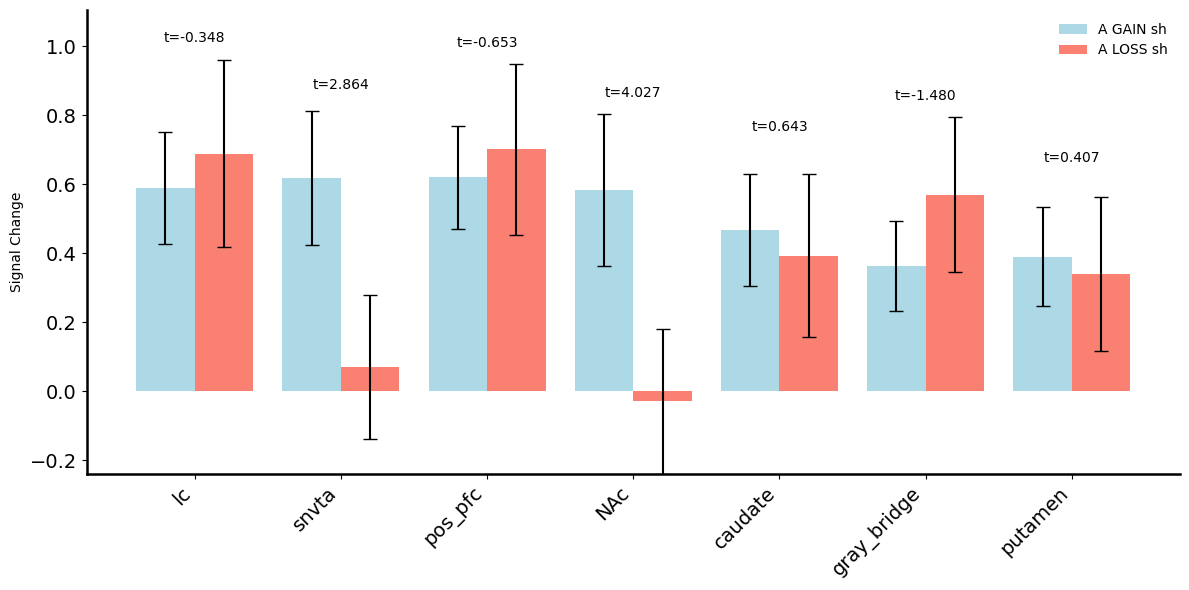

In [ ]:
######################################################
# Combined Bar Plot for All ROIs with Error Bars
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(roi_list))  # X-axis positions
width = 0.4  # Bar width

# Plot each coefficient as a paired bar with error bars
bars1 = ax.bar(x - width/2, all_roi_data[:, 0], width, label=coef_list1[0],
               color='lightblue', yerr=all_roi_sem[:, 0], capsize=5)
bars2 = ax.bar(x + width/2, all_roi_data[:, 1], width, label=coef_list1[1],
               color='salmon', yerr=all_roi_sem[:, 1], capsize=5)
# Set Y-axis limit to accommodate text annotations
max_y = np.max(all_roi_data + all_roi_sem)
min_y = np.min(all_roi_data - all_roi_sem)
ax.set_ylim(min_y, max_y*1.15)
# Annotate t-values and p-values above each pair of bars 
for i in range(len(roi_list)):
    ax.text(x[i], max(all_roi_data[i]) + max(all_roi_sem[i]) + 0.05, 
            f"t={all_t_stats[i]:.3f}", 
            ha='center', fontsize=10, color='black')

ax.set_xticks(x)
ax.set_xticklabels(roi_list, rotation=45, ha='right')
ax.set_ylabel("Signal Change")
# ax.set_title("Mean Signal Change Across ROIs with Error Bars")
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(axis='x', labelsize=14)
ax.legend()
# ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.legend(frameon=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.8)  
ax.spines['bottom'].set_linewidth(1.8)
# plt.show()
plt.tight_layout()
plt.savefig("output/roi_gl.png", dpi=300, bbox_inches='tight')
print("++ save fig to the server")

++ saved output/roi_gl_violin_slope_single.png


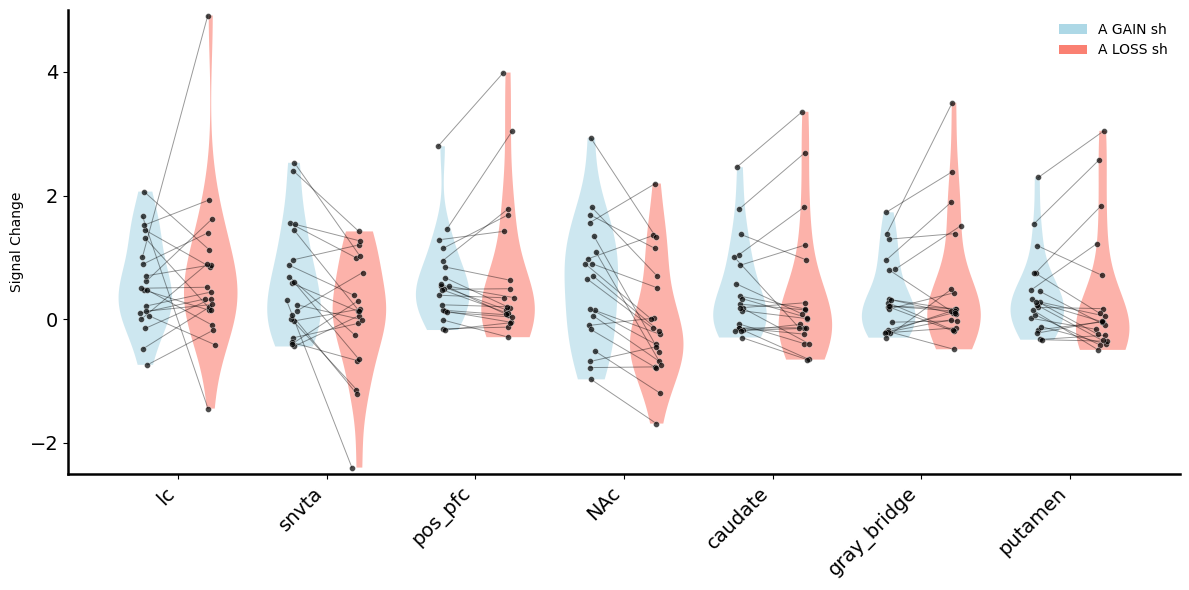

In [ ]:
# %% Violin + paired slope (Gain → Loss) in ONE plot across all ROIs
import numpy as np, matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.patches import Patch
from scipy.stats import t

fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(roi_list))
offset   = 0.22          # half-distance between Gain and Loss per ROI
vwidth   = 0.36
JITTER_SD = 0.02
rng = np.random.default_rng(7)

gain_color, loss_color = 'lightblue', 'salmon' 
GAIN_LABEL, LOSS_LABEL = 'A GAIN sh', 'A LOSS sh'

# y-limit like your bar plot for consistency
max_y = np.max(all_roi_data + all_roi_sem)
min_y = np.min(all_roi_data - all_roi_sem)
ax.set_ylim(-2.5, 5)

for i in range(len(roi_list)):
    gain = np.asarray(all_roi_gain_subject[i], float)
    loss = np.asarray(all_roi_loss_subject[i], float)

    # --- violins (background) ---
    parts = ax.violinplot([gain, loss],
                          positions=[x[i]-offset, x[i]+offset],
                          widths=vwidth,
                          showmeans=False, showmedians=False, showextrema=False)
    parts['bodies'][0].set_facecolor(gain_color); parts['bodies'][0].set_alpha(0.6); parts['bodies'][0].set_edgecolor('none')
    parts['bodies'][1].set_facecolor(loss_color); parts['bodies'][1].set_alpha(0.6); parts['bodies'][1].set_edgecolor('none')

    # --- paired slope lines + points (use SAME jitter on both ends so the line hits both dots) ---
    n = gain.size
    base = rng.normal(0, JITTER_SD, size=n)  # same jitter used for both ends
    xg = x[i] - offset + base
    xl = x[i] + offset + base

    # lines first (under the points)
    for j in range(n):
        ax.plot([xg[j], xl[j]], [gain[j], loss[j]],
                color='k', alpha=0.4, lw=0.7, zorder=4)

    # dots
    ax.scatter(xg, gain, s=18, alpha=0.7, color='k', linewidth=0.3, edgecolor='white', zorder=5)
    ax.scatter(xl, loss, s=18, alpha=0.7, color='k', linewidth=0.3, edgecolor='white', zorder=5)

# # cosmetics/labels/legend
# ax.axhline(0, color='k', lw=1, alpha=0.6)
ax.set_xticks(x)
ax.set_xticklabels(roi_list if 'roinm_list' in globals() else roi_list, rotation=45, ha='right')
ax.set_ylabel("Signal Change")
ax.tick_params(axis='y', labelsize=14); ax.tick_params(axis='x', labelsize=14)
ax.yaxis.set_major_locator(MaxNLocator(4))
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.8); ax.spines['bottom'].set_linewidth(1.8)

ax.legend(handles=[
    Patch(facecolor=gain_color, label=GAIN_LABEL),
    Patch(facecolor=loss_color, label=LOSS_LABEL)
], frameon=False, loc='upper right')

plt.tight_layout()
plt.savefig("output/roi_gl_violin_slope_single.png", dpi=300, bbox_inches='tight')
print("++ saved output/roi_gl_violin_slope_single.png")